# Code for experiments with ENOT and gaussian benchmark

## 1. Imports

In [1]:
import matplotlib
import math
import gc
import wandb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm, inv

from src.fid_score import calculate_frechet_distance
from src import distributions
from src.tools import unfreeze, freeze

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import torch
import numpy as np

from matplotlib import pyplot as plt

from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.categorical import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.decomposition import PCA
from scipy.stats import ortho_group
from scipy.linalg import sqrtm, inv
from sklearn.decomposition import PCA

from scipy.special import gamma
from src.gaussian_benchmark import GaussianBenchmark, get_gaussian_benchmark
from src.ENOT import SDE, calculate_noise_norm, MMD, integrate
from src.neural_networks import make_net
from src.metrics import MMD, compute_BW_UVP

In [2]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [3]:
DIM = 2
EPS = 10
assert DIM > 1

L1 = 1e-10
GPU_DEVICE = 1
BATCH_SIZE = 128
EPSILON = EPS
N_STEPS = 10
TIME_DIM = 1
T_LR = 1e-4
D_LR = 1e-4
T_ITERS = 10
CONSTANT_TIME = False
USE_POSITIONAL_ENCODING = False
INTEGRAL_SCALE = 1/(DIM)
T_GRADIENT_MAX_NORM = float("inf")
D_GRADIENT_MAX_NORM = float("inf")
IS_RESNET_GENERATOR = False
PREDICT_SHIFT = True

T_N_HIDDEN = 512
T_N_LAYERS = 3

D_N_HIDDEN = 512
D_N_LAYERS = 3

MAX_STEPS = 10000
METRICS_INTERVAL = 100
SEED = 42
CONTINUE = -1

In [4]:
EXP_NAME = f'Gaussians_test_EPSILON_{EPSILON}_STEPS_{N_STEPS}_DIM_{DIM}'

config = dict(
    DIM=DIM,
    T_ITERS=T_ITERS,
    D_LR=D_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE,
    N_STEPS=N_STEPS,
    EPSILON=EPSILON,
    CONSTANT_TIME=CONSTANT_TIME,
    USE_POSITIONAL_ENCODING=USE_POSITIONAL_ENCODING,
    TIME_DIM=TIME_DIM,
    INTEGRAL_SCALE=INTEGRAL_SCALE,
    T_GRADIENT_MAX_NORM=T_GRADIENT_MAX_NORM,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    IS_RESNET_GENERATOR=IS_RESNET_GENERATOR,
    T_N_HIDDEN=T_N_HIDDEN,
    T_N_LAYERS=T_N_LAYERS,
    D_N_HIDDEN=D_N_HIDDEN,
    D_N_LAYERS=D_N_LAYERS,
    PREDICT_SHIFT=PREDICT_SHIFT
)

In [5]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## 3. Initialize Benchmark

In [6]:
torch.manual_seed(SEED); np.random.seed(SEED);
benchmark = get_gaussian_benchmark(DIM, EPS, f"cuda:{GPU_DEVICE}", download=False)

X_sampler = benchmark.X_sampler
Y_sampler = benchmark.Y_sampler

In [7]:
pca = PCA(n_components=2)

samples, labels = X_sampler.sample(10000)
samples = samples.cpu()

target_samples, target_labels = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

pca.fit(torch.cat((samples, target_samples)))

PCA(n_components=2)

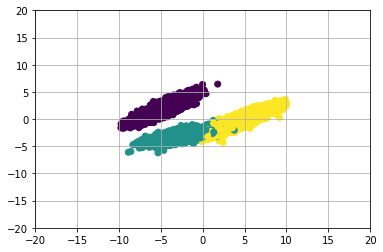

In [8]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1], c=labels)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

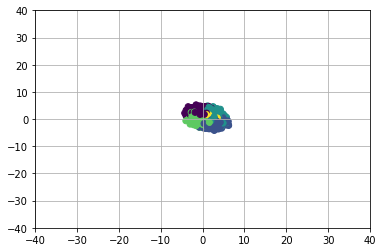

In [9]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1], c=target_labels)
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

## 6. Model initialization

In [10]:
D = make_net(DIM, 1, n_layers=D_N_LAYERS, n_hiddens=D_N_HIDDEN).cuda()
    
T = make_net(DIM+TIME_DIM, DIM, n_layers=T_N_LAYERS, n_hiddens=T_N_HIDDEN).cuda()
T = SDE(T, EPSILON, N_STEPS, TIME_DIM, IS_RESNET_GENERATOR, 
        predict_shift=PREDICT_SHIFT, use_positional_encoding=USE_POSITIONAL_ENCODING,
        constan_time=CONSTANT_TIME).cuda()

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

T params: 528390
D params: 527361


In [11]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10, betas=(0, 0.999))
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10, betas=(0, 0.999))

if CONTINUE > -1:
    T_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{CONTINUE}.pt')))
    T.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'T_{SEED}_{CONTINUE}.pt')))
    D_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_opt_{SEED}_{CONTINUE}.pt')))
    D.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_{SEED}_{CONTINUE}.pt')))

## 7. Training

In [12]:
wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: Currently logged in as: schrodinger_bridge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


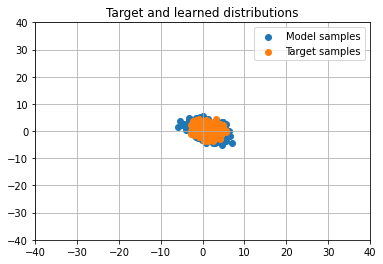

  6%|▌         | 554/10000 [07:37<2:09:52,  1.21it/s] 


KeyboardInterrupt: 

In [13]:
metrics = []

noise_norm = calculate_noise_norm(DIM, N_STEPS, EPSILON)
wandb.log({f'Noise norm' : noise_norm}, step=0)

torch.manual_seed(SEED); np.random.seed(SEED)

### metrics
X = X_sampler.sample(1000)[0]
Y = Y_sampler.sample(1000)[0]
norm_mmd = MMD(X, Y, kernel="rbf", device="cuda", scale_factor=DIM)
wandb.log({f'norm_mmd' : norm_mmd}, step=0)
###

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    unfreeze(T); freeze(D)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        
        X0, X1 = X_sampler.sample(BATCH_SIZE)[0], Y_sampler.sample(BATCH_SIZE)[0]
#         X0.requires_grad_()
        
        trajectory, times, shifts = T(X0)
        XN = trajectory[:, -1]
        norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1)**2
        integral = INTEGRAL_SCALE*integrate(norm, times)
        
        T_loss = (integral + D(X1) - D(XN)).mean()
        T_loss.backward()
        T_gradient_norm = torch.nn.utils.clip_grad_norm_(T.parameters(), max_norm=T_GRADIENT_MAX_NORM)
        T_opt.step()
    
    wandb.log({f'T gradient norm' : T_gradient_norm.item()}, step=step)
    wandb.log({f'Mean norm' : torch.sqrt(norm).mean().item()}, step=step)
    wandb.log({f'T_loss' : T_loss.item()}, step=step)
        
    del T_loss, X0, X1, XN; gc.collect(); torch.cuda.empty_cache()
        
    freeze(T); unfreeze(D)
    
    D_opt.zero_grad()
    
    X0, X1 = X_sampler.sample(BATCH_SIZE)[0], Y_sampler.sample(BATCH_SIZE)[0]
    trajectory, times, shifts = T(X0)
    XN = trajectory[:, -1]
    norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1)**2
    integral = INTEGRAL_SCALE*integrate(norm, times)
    
    D_X1 = D(X1)
    D_XN = D(XN)
    
    D_loss = (-integral - D_X1 + D_XN).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step()
    
    wandb.log({f'D gradient norm' : D_gradient_norm.item()}, step=step)
    wandb.log({f'D_loss' : D_loss.item()}, step=step)
    
    wandb.log({f'integral' : integral.mean().item()}, step=step)
    wandb.log({f'D_X1' : D_X1.mean().item()}, step=step)
    wandb.log({f'D_XN' : D_XN.mean().item()}, step=step)
    del D_loss, X0, X1, XN; gc.collect(); torch.cuda.empty_cache()
    
    if step % METRICS_INTERVAL == 0:
        X = X_sampler.sample(1000)[0]
        Y = Y_sampler.sample(1000)[0]

        with torch.no_grad():
            trajectory, times, shifts = T(X)
            XN = trajectory[:, -1]

        Y_pca = pca.transform(Y.cpu())
        XN_pca = pca.transform(XN.detach().cpu())
        
        clear_output(wait=True)
        plt.scatter(XN_pca[:, 0], XN_pca[:, 1], label="Model samples")
        plt.scatter(Y_pca[:, 0], Y_pca[:, 1], label="Target samples")
        plt.legend()
        plt.grid()
        plt.title("Target and learned distributions")
        plt.xlim(-40, 40)
        plt.ylim(-40, 40)
        plt.show()
        
        # mmd
        mmd = MMD(Y, XN, kernel="rbf", device="cuda", scale_factor=DIM)/norm_mmd
        wandb.log({f'MMD_model_target' : mmd}, step=step)
        
        Y = Y_sampler.sample(1000)[0]
        Y_prime = Y_sampler.sample(1000)[0]

        mmd = MMD(Y, Y_prime, kernel="rbf", device="cuda", scale_factor=DIM)/norm_mmd
        wandb.log({f'Y_sampler_mmd' : mmd}, step=step)
        
        # bw-uvp
        X = X_sampler.sample(100000)[0]
        Y = Y_sampler.sample(100000)[0]
        with torch.no_grad():
            trajectory, times, shifts = T(X)
            XN = trajectory[:, -1]
            
            bw_uvp = compute_BW_UVP(XN.cpu().numpy(), Y.cpu().numpy())
            wandb.log({f'BW-UVP_target' : bw_uvp}, step=step)

    gc.collect(); torch.cuda.empty_cache()